# BAX Emittance Minimization (LCLS-II)
In this notebook, we hope to demonstrate Bayesian Algorithm Execution (BAX) in Xopt as a means of minimizing the emittance at LCLS-II. BAX is a generalization of Bayesian Optimization that seeks to acquire observations that provide our model with maximal information about our property of interest. In this example, our property of interest is the minimal emittance and its location in tuning-parameter-space. See https://arxiv.org/pdf/2209.04587.pdf for details.

# Imports

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

# append path to parent directory (SLAC_Xopt)
import os
import sys
sep = '\\'
split_path = os.getcwd().split(sep)
parent_path = sep.join(split_path[:-3])
sys.path.append(parent_path)

import matplotlib.pyplot as plt
# import os    
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator

from xopt.evaluator import Evaluator

from emitopt.utils import (post_path_emit_squared,
                           compute_emits,
                           get_meas_scan_inputs_from_tuning_configs,
                           get_valid_emittance_samples)
from emitopt.sampling import draw_product_kernel_post_paths
from emitopt.algorithms import ScipyMinimizeEmittance

import time
import numpy as np
import random

# Use CUDA if available

In [2]:
# if torch.cuda.is_available():
if False:
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
    use_cuda = True
else:
    torch.set_default_tensor_type('torch.DoubleTensor')
    use_cuda = False

# General settings

In [3]:
n_obs_init = 3 # number of random initial observations for GP model
n_iter = 25 # number of optimization steps for Xopt to take (after acquiring random initial data)
var_file = '../variables.csv'

# # emittance measurement info
# beam_energy = # the beam energy in GeV
# q_len = # the measurement quad thickness [m]
# distance = # the drift length from measurement quad to observation screen [m]

# random seeds for reproducibility
rand_seed = 2
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) # only(?) affects initial random observations through Xopt 
random.seed(rand_seed)

# Evaluator

# VOCS

In [4]:
from scripts.variables import read_variables_from_csv, write_variables_to_csv

# fetch variables
variables = read_variables_from_csv(var_file)
variables

{'SOLN:GUNB:212:BCTRL': [0.042826, 0.044574],
 'SOLN:GUNB:823:BCTRL': [0.0245, 0.0255],
 'QUAD:GUNB:212:1:BCTRL': [-0.005, 0.005],
 'QUAD:GUNB:212:2:BCTRL': [-0.005, 0.005],
 'QUAD:GUNB:823:1:BCTRL': [-0.005, 0.005],
 'QUAD:GUNB:823:2:BCTRL': [-0.005, 0.005],
 'QUAD:HTR:120:BCTRL': [-4.48035, 4.479]}

In [86]:
# constants
constants = {
            "screen": "OTRS:HTR:330",
            "threshold": ,
            }

# construct vocs
vocs = VOCS(
    variables = variables,
    constants = constants,
    objectives = {'sqrt_norm_emit_xy': 'MINIMIZE'}
)

# BAX algorithm

In [ ]:
from emitopt.utils import get_quad_strength_conversion_factor
scale_factor = get_quad_strength_conversion_factor(E=beam_energy, q_len=q_len)
algo_kwargs = {
        'scale_factor': scale_factor,
        'q_len': q_len,
        'distance': distance,
        'n_samples': 20,
        'meas_dim': meas_dim,
        'n_steps_measurement_param': 10,
        'n_steps_exe_paths':  10}
algo = ScipyMinimizeEmittance(**algo_kwargs)

# Product kernel model constructor

In [6]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt.generators.bayesian.bax_generator import BaxGenerator
from emitopt.algorithms import ScipyMinimizeEmittance

# get dimension index for measurement device
meas_param = 'QUAD:HTR:120:BCTRL' # assign measurement parameter
meas_dim = list(vocs.variables).index(meas_param)
print('meas_dim =', meas_dim)

# make list of all other device dimension indeces
tuning_dims = list(range(vocs.n_variables))
tuning_dims.remove(meas_dim)

# prepare product kernel (Matern x Quadratic)
covar_module = MaternKernel(active_dims=tuning_dims, lengthscale_prior=GammaPrior(3.0, 6.0)) * PolynomialKernel(
    power=2, active_dims=[meas_dim]
)
scaled_covar_module = ScaleKernel(covar_module, outputscale_prior=GammaPrior(2.0, 0.15))   

# prepare options for Xopt generator
covar_module_dict = {'sqrt_norm_emit_xy': scaled_covar_module}

model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=True)

# Construct generator, evaluator, Xopt objects

In [7]:
#construct BAX generator
generator = BaxGenerator(vocs=vocs, model_constructor=model_constructor, algorithm=algo, use_cuda=use_cuda)

#construct evaluator
evaluator = Evaluator(function=test_func)

#construct Xopt optimizer
optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

# Optimize

In [8]:
# call X.random_evaluate() to generate random initial points and evaluate on test_func
optimizer.random_evaluate(n_obs_init)

x0         x1           y  emittance  xopt_runtime  xopt_error
1 -0.743980   5.174209   63.569817   3.008351      0.000640       False
2  0.896295   6.370576   84.974747   3.492162      0.000218       False
3 -1.198650  13.573214  232.129856   4.718769      0.000304       False

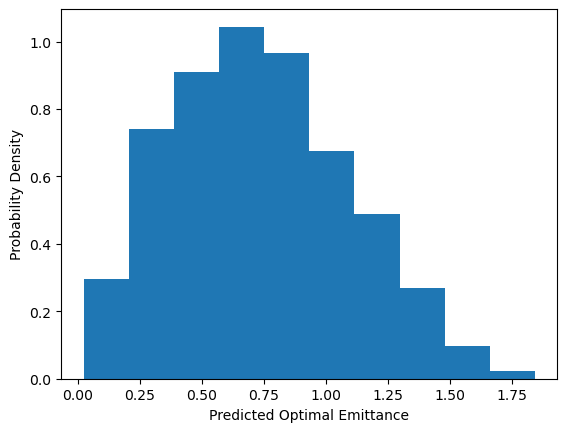

sample validity rate: tensor([0.1265])
Iteration: 1 / 25
This iteration took: 5.562591314315796 seconds.

Iteration: 2 / 25
This iteration took: 2.520416498184204 seconds.

Iteration: 3 / 25
Scipy failed to find at least 3 physically valid solutions.
This iteration took: 1.3702845573425293 seconds.

Iteration: 4 / 25
Scipy failed to find at least 3 physically valid solutions.
This iteration took: 1.1636667251586914 seconds.

Iteration: 5 / 25
Scipy failed to find at least 3 physically valid solutions.
This iteration took: 0.8794224262237549 seconds.



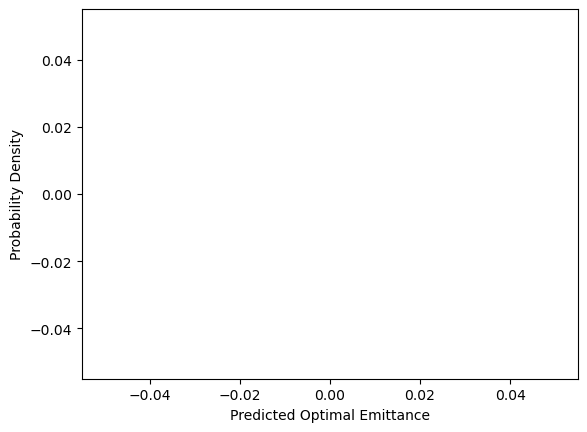

sample validity rate: tensor([0.])
Iteration: 6 / 25
This iteration took: 9.02418327331543 seconds.

Iteration: 7 / 25
This iteration took: 5.739625692367554 seconds.

Iteration: 8 / 25
This iteration took: 7.810025930404663 seconds.

Iteration: 9 / 25
This iteration took: 7.092968702316284 seconds.

Iteration: 10 / 25
This iteration took: 7.638046741485596 seconds.



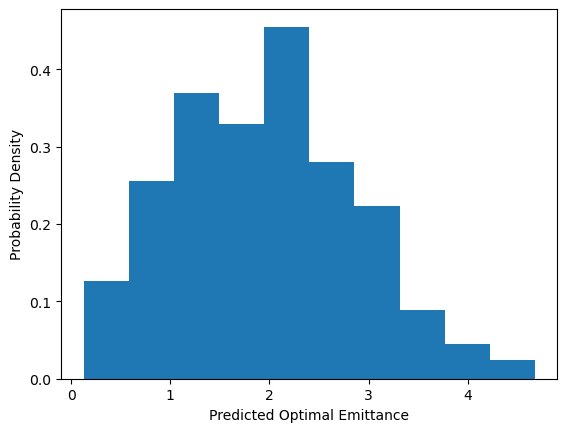

sample validity rate: tensor([0.0541])
Iteration: 11 / 25
This iteration took: 4.861624717712402 seconds.

Iteration: 12 / 25
This iteration took: 4.941431999206543 seconds.

Iteration: 13 / 25
This iteration took: 5.091416358947754 seconds.

Iteration: 14 / 25
This iteration took: 5.190473556518555 seconds.

Iteration: 15 / 25
This iteration took: 9.738130331039429 seconds.



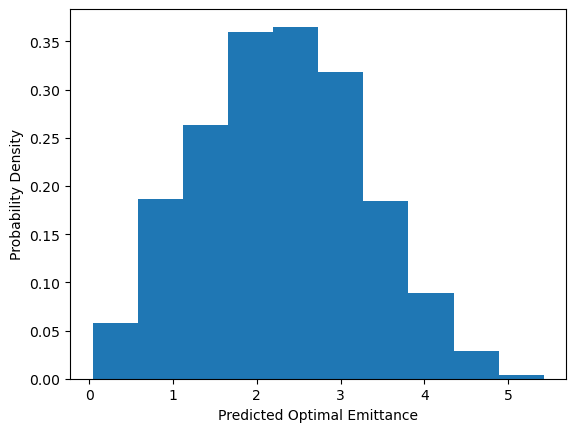

sample validity rate: tensor([0.3082])
Iteration: 16 / 25
This iteration took: 8.988223552703857 seconds.

Iteration: 17 / 25
This iteration took: 6.433661699295044 seconds.

Iteration: 18 / 25
This iteration took: 15.973903179168701 seconds.

Iteration: 19 / 25
This iteration took: 13.13979172706604 seconds.

Iteration: 20 / 25
This iteration took: 7.521343946456909 seconds.



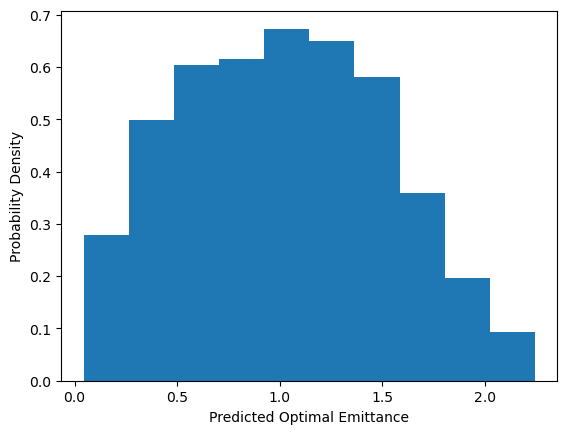

sample validity rate: tensor([0.0392])
Iteration: 21 / 25
This iteration took: 3.9619295597076416 seconds.

Iteration: 22 / 25
This iteration took: 7.403325796127319 seconds.

Iteration: 23 / 25
This iteration took: 8.652895450592041 seconds.

Iteration: 24 / 25
This iteration took: 8.727697849273682 seconds.

Iteration: 25 / 25
This iteration took: 19.1471049785614 seconds.



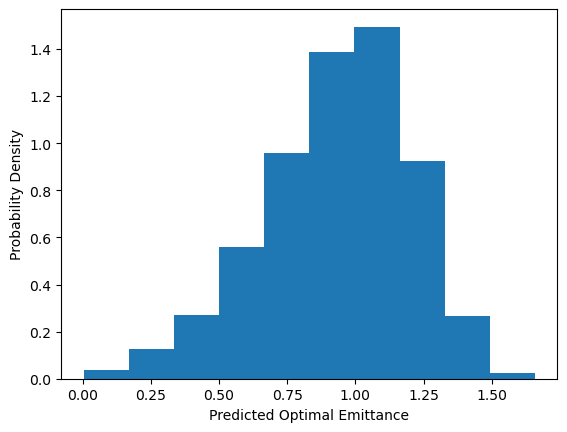

sample validity rate: tensor([0.9466])


In [10]:
#get initial emittance prediction at ground truth optimum
beam_size_model = optimizer.generator.train_model().models[0]


#get mean-predicted optimal tuning config and eval predicted emits at this location in tuning parameter space
algo = optimizer.generator.algorithm
X_tuned, emits_at_target_valid, emits_sq_at_target, is_valid, svr = algo.mean_output(beam_size_model, 
                                                                                     torch.tensor(vocs.bounds), 
                                                                                     num_restarts=10)


plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
plt.xlabel('Predicted Optimal Emittance')
plt.ylabel('Probability Density')
plt.show()
print('sample validity rate:', svr)

for i in range(1, n_iter+1):

    print('Iteration:', i, '/', n_iter)

    start = time.time()

    # call X.step() to generate a random initial point and evaluate on test_func
    optimizer.step()    

    
    #extract GP model hyperparams
    beam_size_model = optimizer.generator.model.models[0]

    #get mean-predicted optimal tuning config and eval predicted emits at this location in tuning parameter space
    algo = optimizer.generator.algorithm
    X_tuned, emits_at_target_valid, emits_sq_at_target, is_valid, svr = algo.mean_output(beam_size_model,
                                                                                         torch.tensor(vocs.bounds),
                                                                                         num_restarts=10)
    
    end = time.time()
    print('This iteration took:', end-start, 'seconds.\n')

    if i % 5 == 0:
        plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
        plt.xlabel('Predicted Optimal Emittance')
        plt.ylabel('Probability Density')
        plt.show()
        print('sample validity rate:', svr)